## Genetic Algorithm


In [88]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import random
from sympy import symbols, sympify, lambdify, simplify
import time
import copy


### Obtaining the data

In [89]:
doc2 = open("C:/Users/antoc/Downloads/PortableGit/practica2024/hub_data.txt")
lineas2 = doc2.readlines()

# Dividing each line into different columns using a space for separation.
datos_separados2 = [linea.strip().split(' ') for linea in lineas2]

datos= []
for fila in datos_separados2:
    datos.append(fila)

z = []
for i in range(len(datos)):
      a = float(datos[i][0])
      z.append(a)
z =np.array(z)

H = []
for i in range(len(datos)):
   if datos[i][1] == '':
      a = float(datos[i][2])
      H.append(a)
   else:
      a = float(datos[i][1])
      H.append(a)
H = np.array(H)

desv = []
for i in range(len(datos)):
    a = float(datos[i][2])
    desv.append(a)


### Objective

The algorithm minimizes the $\chi^2 = \sum_{i=1}^{N} (\dfrac{y_i - f(x_i)}{\sigma_{i}})^2$ with the objective of obtaining the function $f(x)$ that best fit the data. 

In [90]:
def polix(x):
    return x**x
def poli1(x):
    return (x+1) 
def poli2(x):
    return x**2
def poli3(x):
    return x**3

# Create list with coefficients
coeficientes = [random.random() for i in range(5)]
# Create list with constant functions. Those are values between 0 and 1.
funciones_c = [lambda x, i=i: coeficientes[i] for i in range(5)]

# Initial grammar containing a list of initial functions.
grammar = [polix, poli1, poli2, poli3] + funciones_c
operaciones = ['+', '-', '*', '/']


In [91]:
# Calculate the $\chi^2$ from the initially entered functions.
'''
def chi_2_f(f):
    chi_2 = 0
    j = 0
    while j+1 <= len(H):
        chi_2 += np.sum(np.square((H[j] - f(z[j]))/desv[j]))
        j += 1
    return chi_2
'''
def chi_2_f(f):
    # Calcular las diferencias y cuadrados de las diferencias
    diff = (H - f(z)) / desv
    squared_diff = np.square(diff)

    # Sumar los cuadrados de las diferencias
    chi_2 = np.sum(squared_diff)

    return chi_2


### Combine initial functions.

The initial functions are combined with operations between them until a defined number of initial functions is reached. A number of initial functions were chosen because it will increase the number of individuals as crossover and mutation are applied to the initial functions ('longitud final').

In [92]:
def juntar_elementos_inicial(funciones, operaciones, longitud_final=100):
    final = []
    while len(final) < longitud_final * 3:
        random_funcion1 = random.choice(funciones)
        random_funcion2 = random.choice(funciones)
        random_operador = random.choice(operaciones)

        final.append(random_funcion1)
        final.append(random_operador)
        final.append(random_funcion2)

    #Create a list of sublists to represent the rows
    resultado_final_inicial = [final[i:i+3] for i in range(0, len(final), 3)]

    return resultado_final_inicial

# In order to print the initial functions, you can utilize:
#for fila in resultado_final_inicial:
#    print(fila)


### Transform the list into a function

In order to obtain the $\chi^2$, convertir_lista_a_str is defined to convert a list of functions (grammar) and strings (operations) into a function. If one function is next to another in the list of functions and operators, it means that the operation between them is composition of functions.

In [93]:

#The term "x" should be enclosed in parentheses to avoid confusion with other occurrences of "x" in the string.
def a_string(funcion):
    if funcion == polix:
        return '(x)**(x)'
    elif funcion == poli1:
        return '((x)+1)'
    elif funcion == poli2:
        return '(x)**2'
    elif funcion == poli3:
        return '(x)**3'
    for i in range(len(funciones_c)):
        if funcion == funciones_c[i]:
            return str(coeficientes[i])
    else:
        return str(funcion)

# 'pasar_a_funcion' turn a string into a function.
x = symbols('x')
def pasar_a_funcion(expresion):
    a_sympy = sympify(expresion)
    a_python = lambdify(x, a_sympy, 'numpy')
    return a_python

# composicion takes a list of functions as strings and creates the composition of those.
def composicion(lista):
    modi_int = a_string(lista[-1])
    #print(modi_int)
    for i in range(2,len(lista)+1):
        modi_ext = a_string(lista[-i])
        modi_int = modi_ext.replace('(x)', '('+ modi_int +')' )
    return modi_int

# convertir_lista_a_str takes a list of 
def convertir_lista_a_str(lista):
    string=''
    for i in range(len(lista)):
        if callable(lista[i]):
            if i != 0 and callable(lista[i - 1]):
                string = string
            elif i < len(lista) - 1 and callable(lista[i + 1]):
                compo = []
                for j in range(i, len(lista)):
                    if callable(lista[j]):
                        compo.append(lista[j])

                string += composicion(compo)
            
            else:  
                string += a_string(lista[i])
        else:
            string += lista[i]

    return string

#lista_prueba = [poli2, '+', poli1,'-',poli1, poli2, funciones_c[0] ,'-', poli1]
#funcion_prueba= convertir_lista_a_str(lista_prueba)
#print(funcion_prueba)

def convertir_lista_a_funcion(lista):
    string = convertir_lista_a_str(lista)
    func= pasar_a_funcion(string)
    return func


### Calculate the $\chi^2$ for the initial population and select the best functions.

- 'tasa_seleccion' defines the number of best functions that are going to survive.
- 'tasa_cruce' defines the number of functions that are going to survive even if they are not the best-fitting ones.

In [94]:
def mejores(resultado_final, tasa_seleccion = 0.2, tasa_cruce =0.3):
    chis =[]
    for fila in resultado_final:
        a = convertir_lista_a_funcion(fila)
        chi_combinaciones = chi_2_f(a)
        chis.append(chi_combinaciones)
    

    # It select the elements to combine
    cant_sobrevivientes = tasa_seleccion*len(chis)
    cant_sobreviv = int(cant_sobrevivientes)
    #print('Cantidad de sobrevientes:' , cant_sobreviv)

    # Number of the best elements(functions with the lower $\chi^2$).
    num_elementos = cant_sobreviv
    # Obtain the indices and values of the smallest elements in order.
    indices_valores_menores = sorted(enumerate(chis), key=lambda x: x[1])[:num_elementos]
    # Separate the indices and values into different lists.
    indices_menores, valores_menores = zip(*indices_valores_menores)

    f_mejores= []
    for numero in indices_menores:
        f_mejores.append(resultado_final[numero])


    ''' 
    Allowing some offspring, even if less favorable, to survive. 
    This is because one mutation i may be bad, but the i+1 mutation could be better.
    '''

    # Get the indices and values of the not-so-small elements in order.    
    indices_valores_mayores = sorted(enumerate(chis), key=lambda x: x[1])[num_elementos:]
    # Separate the indices and values into different lists.
    indices_mayores, valores_mayores = zip(*indices_valores_mayores)
    for numero in indices_mayores:
        probabilidad = random.random()
        if probabilidad < tasa_cruce:
            f_mejores.append(resultado_final[numero])

    return f_mejores, valores_menores


### Crossover

Combine random parts of the solutions from the parents (composition of functions and addition, multiplication, etc., with each other). 

The selection is used to let through a certain percentage, which will have to mate and mutate. That is, the number decreases with the selection but increases with the crossover and mutation. For each crossover element, a number offspring are produced as a result of combinations with other parents ('hijos_por_padre').

The best element remains constant.

In [95]:
def a_combinar(padres, hijos_por_padre):
    # Create a list with 6 random equations of the best functions to combine.
    combinar = [random.choice(padres) for i in range(hijos_por_padre)]

    # Separate functions and operations for each function to be combined with the selected one.
    combinar_con = []
    for k in range(len(combinar)):
        # 'funciones_combinar' is a list wih the functions to combine.
        funciones_combinar = []
        for j in range(len(combinar[k])):
            if callable(combinar[k][j]):  # Check if it is a function.
                funciones_combinar.append(combinar[k][j])


        # For each equation, choose a function from the list of functions for that equation
        combinar_con.append(random.choice(funciones_combinar)) # Choose a function from the available ones

    return combinar_con



def crossover(padres, hijos_por_padre = 5):
    hijos = []
    hijos.append(padres[0])
    for i in range(1, len(padres)):

        # If the length of the parents is less than a limit (15), add elements; if it is greater, change elements.
        if len(padres[i]) <= 15:
            # Add a combined operator and function, a combined function, or replace it with that of another parent for each offspring.
            numero_random = [random.randint(0,1) for i in range(hijos_por_padre)]
            for k in range(hijos_por_padre):
                hijos_ = copy.deepcopy(padres[i])
                if numero_random[k] == 0:
                    random_operador = random.choice(operaciones)
                    hijos_.append(random_operador)
                    hijos_.append(a_combinar(padres, hijos_por_padre)[k])
                else:
                    hijos_.append(a_combinar(padres, hijos_por_padre)[k])
            
                # Add the offspring to the final list.
                hijos.append(hijos_)


        else:
            for k in range(hijos_por_padre):
                hijos_ = copy.deepcopy(padres[i])
                random_operador = random.choice(operaciones) 
                #j is the index of an element in 'hijos_'.
                j = random.randint(0, len(hijos_)-1)
                if callable(hijos_[j]):
                    hijos_[j] = a_combinar(padres, hijos_por_padre)[k]
                else:
                    hijos_[j] = random_operador
                    hijos_[j+1] = a_combinar(padres, hijos_por_padre)[k]
                
                # Add the offspring to the final list.
                hijos.append(hijos_)

    return hijos

### Mutation

- 'tasa_mutación' defines the probability of mutation.

This mutates one operation for another and one function for another. The best elements remains constant.

In [96]:
def mutar(padres, tasa_mutacion= 0.05):
    hijos = copy.deepcopy(padres)
    for lista in hijos:
        for i in range(1, len(lista)):
            # Generates a number between 0 y 1
            probabilidad = random.random()

            # Verifying if the random number is lower than the desired probability
            if probabilidad < tasa_mutacion:
                if callable(lista[i]):
                    lista[i] = random.choice(grammar)
                else:
                    lista[i] = random.choice(operaciones)
    return hijos



### Recurrence

In [97]:
chi_por_generaciones = []
def recurrencia(gener):
    poblacion_inicial = juntar_elementos_inicial(grammar, operaciones, longitud_final= 100)

    # Measure the execution time of the function.
    inicio_tiempo = time.time() 

    # Best functions from the initial population.
    mejores_inicial = mejores(poblacion_inicial, tasa_seleccion = 0.2, tasa_cruce =0.3)[0]

    generaciones =0
    while generaciones <= gener:
        generaciones +=1
                
        # Obtain the best functions from the enhanced population.
        mejor_func_chi= mejores(mutar(crossover(mejores_inicial, hijos_por_padre= 6),  tasa_mutacion= 0.05), tasa_seleccion = 0.2, tasa_cruce =0.3)

        mejores_actual = mejor_func_chi[0]
        chi_mejores = mejor_func_chi[1]
        mejores_inicial = mejores_actual
        
        mejores_str = []
        for i in range(len(mejores_actual)):
            mejores_str.append(convertir_lista_a_str(mejores_actual[i]))

        if len(mejores_str)>= 100:
            mejores_actual = mejores_actual[:80]
            mejores_inicial = mejores_actual


        #print(f"Mejores funciones en esta iteración: {mejores_str}")
        print(f"Largo mejores funciones en esta iteración: {len(mejores_str)}")
        #print(f"Chi^2: {chi_mejores}")
        print(f"generación: {generaciones}")
        
        # The best chi value for each generation is added to a list.
        chi_por_generaciones.append(chi_mejores[0])
        #print(f"Chi^2 por generación: {chi_por_generaciones}")

    fin_tiempo = time.time()

    tiempo_total = fin_tiempo - inicio_tiempo
    print(f"El tiempo de ejecución fue: {tiempo_total} segundos")

    return mejores_str, chi_por_generaciones

# 'generaciones_evaluar' are the number of generations for the algorithm.
generaciones_evaluar = 50
recu = recurrencia(generaciones_evaluar)


Largo mejores funciones en esta iteración: 117
generación: 1
Largo mejores funciones en esta iteración: 208
generación: 2
Largo mejores funciones en esta iteración: 208
generación: 3
Largo mejores funciones en esta iteración: 203
generación: 4


<lambdifygenerated-106133>:2: RuntimeWarning: overflow encountered in power
  return (2*x**2 + ((x**2 + 1)**(x**2 + 1) + 1)**(2*(x**2 + 1)**(x**2 + 1) + 2) + 1)
<ipython-input-91-ffc0c6b503fe>:14: RuntimeWarning: overflow encountered in square
  squared_diff = np.square(diff)
<lambdifygenerated-106146>:2: RuntimeWarning: overflow encountered in power
  return (x + 2 + ((x + 4)**3)**((x + 4)**3)/(x + 1))
<lambdifygenerated-106210>:2: RuntimeWarning: overflow encountered in power
  return (x + 1 + ((x**(3*x) + 2)**(x**(3*x) + 2) + 1)/(x**(3*x) + 1))


Largo mejores funciones en esta iteración: 218
generación: 5


<lambdifygenerated-106718>:2: RuntimeWarning: overflow encountered in power
  return (-x**2 + x - 1 + ((x**2 + 4)**3)**((x**2 + 4)**3)/(x + 1))


Largo mejores funciones en esta iteración: 200
generación: 6


<lambdifygenerated-107369>:2: RuntimeWarning: overflow encountered in power
  return (-x**3 + x**2 + ((x**6 + 1)**(x**6 + 1) + 2)**3 + 0.5164149574122983/x**2)


Largo mejores funciones en esta iteración: 205
generación: 7
Largo mejores funciones en esta iteración: 218
generación: 8


<lambdifygenerated-108327>:2: RuntimeWarning: overflow encountered in power
  return (x**2 + (x + 1)**2 + (x + 7)**3 + ((x + 7)**3 + 1)**((x + 7)**3 + 1) - (x + 4)/(x + 1))
<lambdifygenerated-108371>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 43.48108334160771*x + (x**6)**(x**6) + 44.33717968841302)


Largo mejores funciones en esta iteración: 206
generación: 9


<lambdifygenerated-108803>:2: RuntimeWarning: overflow encountered in power
  return (x**2 + x + x**x*(x + 1)*((x + 2)**(x + 2) + 1) + ((x + 2)**(x + 2) + 1)**((x + 2)**(x + 2) + 1) + (((x + 2)**(x + 2) + 1)**((x + 2)**(x + 2) + 1) + 4)**2 + 4)
<lambdifygenerated-108803>:2: RuntimeWarning: overflow encountered in square
  return (x**2 + x + x**x*(x + 1)*((x + 2)**(x + 2) + 1) + ((x + 2)**(x + 2) + 1)**((x + 2)**(x + 2) + 1) + (((x + 2)**(x + 2) + 1)**((x + 2)**(x + 2) + 1) + 4)**2 + 4)


Largo mejores funciones en esta iteración: 206
generación: 10
Largo mejores funciones en esta iteración: 206
generación: 11
Largo mejores funciones en esta iteración: 220
generación: 12
Largo mejores funciones en esta iteración: 206
generación: 13
Largo mejores funciones en esta iteración: 199
generación: 14
Largo mejores funciones en esta iteración: 217
generación: 15


<lambdifygenerated-111348>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + x + x**x*(((x**3 + 2)**3 + 1)**((x**3 + 2)**3 + 1) + 2)**3/((x**3 + 2)*((x**3 + 2)**3 + 1)) + 1.516414957412298)


Largo mejores funciones en esta iteración: 203
generación: 16


<lambdifygenerated-111878>:2: RuntimeWarning: overflow encountered in power
  return (-x**9 + x**3 + x + (x + 1)*((x**9 + 1)**(x**9 + 1) + 4)**3/((x**9 + 1)**(x**9 + 1) + 1) + 0.5164149574122983)
<lambdifygenerated-111878>:2: RuntimeWarning: invalid value encountered in true_divide
  return (-x**9 + x**3 + x + (x + 1)*((x**9 + 1)**(x**9 + 1) + 4)**3/((x**9 + 1)**(x**9 + 1) + 1) + 0.5164149574122983)


Largo mejores funciones en esta iteración: 202
generación: 17
Largo mejores funciones en esta iteración: 223
generación: 18


<lambdifygenerated-112736>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + x**2 + (x + 1)*((x**6)**(3*x**6) + 4)**3/((x**6)**(3*x**6) + 1) - (x**6)**(x**6) + 0.8872668045461051)
<lambdifygenerated-112736>:2: RuntimeWarning: invalid value encountered in true_divide
  return (x**3 + x**2 + (x + 1)*((x**6)**(3*x**6) + 4)**3/((x**6)**(3*x**6) + 1) - (x**6)**(x**6) + 0.8872668045461051)
<lambdifygenerated-112920>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + (x + 1)*(((x**3 + 1)**3)**((x**3 + 1)**3) + 4)**3/(((x**3 + 1)**3)**((x**3 + 1)**3) + 1) - (x**3 + 1)**3 + 0.5164149574122983/(x + 1))
<lambdifygenerated-112920>:2: RuntimeWarning: invalid value encountered in true_divide
  return (x**3 + (x + 1)*(((x**3 + 1)**3)**((x**3 + 1)**3) + 4)**3/(((x**3 + 1)**3)**((x**3 + 1)**3) + 1) - (x**3 + 1)**3 + 0.5164149574122983/(x + 1))


Largo mejores funciones en esta iteración: 200
generación: 19


<lambdifygenerated-113342>:2: RuntimeWarning: overflow encountered in power
  return (x**3 - (x + 1)*((x + 1)**3)**((x + 1)**3) + (x + 1)/(((x + 1)**3)**(3*(x + 1)**3) + 1) + (((x + 1)**3)**(3*(x + 1)**3) + 4)**3 + 0.5164149574122983)
<lambdifygenerated-113406>:2: RuntimeWarning: overflow encountered in power
  return (-x + (x + 1)*(((x + 2)**3)**((x + 2)**3) + 4)**3/(((x + 2)**3)**((x + 2)**3) + 1) - (x + 2)**3 - 1 + 0.5164149574122983/(x + 1))


Largo mejores funciones en esta iteración: 204
generación: 20


<lambdifygenerated-113841>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + (x + 1)*(((x**3 + 1)**(x**3 + 1))**((x**3 + 1)**(x**3 + 1)) + 4)**3/(((x**3 + 1)**(x**3 + 1))**((x**3 + 1)**(x**3 + 1)) + 1) + (x**3 + 1)**(x**3 + 1))
<lambdifygenerated-113841>:2: RuntimeWarning: invalid value encountered in true_divide
  return (x**3 + (x + 1)*(((x**3 + 1)**(x**3 + 1))**((x**3 + 1)**(x**3 + 1)) + 4)**3/(((x**3 + 1)**(x**3 + 1))**((x**3 + 1)**(x**3 + 1)) + 1) + (x**3 + 1)**(x**3 + 1))
<lambdifygenerated-113905>:2: RuntimeWarning: overflow encountered in power
  return (x**2 + (x + 1)*((x**9)**(3*x**9) + 4)**3/((x**9)**(3*x**9) + 1) + 0.5164149574122983 - (x**9)**(x**9)/x**3)
<lambdifygenerated-113905>:2: RuntimeWarning: invalid value encountered in true_divide
  return (x**2 + (x + 1)*((x**9)**(3*x**9) + 4)**3/((x**9)**(3*x**9) + 1) + 0.5164149574122983 - (x**9)**(x**9)/x**3)
<lambdifygenerated-113956>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + (x + 1)*(

Largo mejores funciones en esta iteración: 227
generación: 21


<lambdifygenerated-114283>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + x**3/(x + 1) + (x + 1)*(((x**3)**(3*x**3))**((x**3)**(3*x**3)) + 4)**3*(x**3)**(3*x**3)/(((x**3)**(3*x**3))**((x**3)**(3*x**3)) + 1))
<lambdifygenerated-114283>:2: RuntimeWarning: invalid value encountered in true_divide
  return (x**3 + x**3/(x + 1) + (x + 1)*(((x**3)**(3*x**3))**((x**3)**(3*x**3)) + 4)**3*(x**3)**(3*x**3)/(((x**3)**(3*x**3))**((x**3)**(3*x**3)) + 1))
<lambdifygenerated-114386>:2: RuntimeWarning: overflow encountered in power
  return (-x**9 + x**3 + (x + 1)*((x**9 + 1)**(x**9 + 1) + 4)**3/((x**9 + 1)**(x**9 + 1) + 1) - 1 + 0.5164149574122983/(x + 1))
<lambdifygenerated-114386>:2: RuntimeWarning: invalid value encountered in true_divide
  return (-x**9 + x**3 + (x + 1)*((x**9 + 1)**(x**9 + 1) + 4)**3/((x**9 + 1)**(x**9 + 1) + 1) - 1 + 0.5164149574122983/(x + 1))


Largo mejores funciones en esta iteración: 199
generación: 22


<lambdifygenerated-115013>:2: RuntimeWarning: overflow encountered in power
  return (x**3/(x + 1) - (x + 1)*(x + 2)**3 + (x + 1)*(((x + 2)**3)**((x + 2)**3) + 4)**3/(((x + 2)**3)**((x + 2)**3) + 1))


Largo mejores funciones en esta iteración: 210
generación: 23


<lambdifygenerated-115195>:2: RuntimeWarning: overflow encountered in power
  return (1.127056703661494*x**3 - (x + 1)*(x + 2)**3 + (x + 1)*(((x + 2)**3)**((x + 2)**3) + 4)**3/(((x + 2)**3)**((x + 2)**3) + 1))
<lambdifygenerated-115334>:2: RuntimeWarning: overflow encountered in power
  return (-x**27 + x**3 - (x + 1)/(x**81 + 1) + (x**81 + 3)**(3*x**81 + 9) + 1.0)
<lambdifygenerated-115357>:2: RuntimeWarning: overflow encountered in power
  return ((x + 1)*((x**3 + 2)**2 + 4)**((x**3 + 2)**2 + 4)/((x**3 + 2)**2 + 1) - 2)


Largo mejores funciones en esta iteración: 215
generación: 24


<lambdifygenerated-115826>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + (x + 1)*(x**3 + 1)**2*((x**3 + 1)**6 + 3)**(3*(x**3 + 1)**6 + 9)/((x**3 + 1)**6 + 1) + 1.0)
<lambdifygenerated-115858>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 61.85358051097642*x - ((x**3)**(x**3))**((x**3)**(x**3)) + 61.85358051097642)
<lambdifygenerated-115997>:2: RuntimeWarning: overflow encountered in power
  return (-x**27 + x**3 + (x + 1)*((x**27)**(x**27) + 4)**3/((x**27)**(x**27) + 1) + 0.8872668045461051/(x + 1))
<lambdifygenerated-115997>:2: RuntimeWarning: invalid value encountered in true_divide
  return (-x**27 + x**3 + (x + 1)*((x**27)**(x**27) + 4)**3/((x**27)**(x**27) + 1) + 0.8872668045461051/(x + 1))


Largo mejores funciones en esta iteración: 208
generación: 25


<lambdifygenerated-116069>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + x**2 + (x + 1)*((((x**9)**(x**9))**((x**9)**(x**9)) + 2)**3 + 1)**3/(((x**9)**(x**9))**((x**9)**(x**9)) + 1) - (x**9)**(x**9) + 0.4491022409860974)
<lambdifygenerated-116069>:2: RuntimeWarning: invalid value encountered in true_divide
  return (x**3 + x**2 + (x + 1)*((((x**9)**(x**9))**((x**9)**(x**9)) + 2)**3 + 1)**3/(((x**9)**(x**9))**((x**9)**(x**9)) + 1) - (x**9)**(x**9) + 0.4491022409860974)
<lambdifygenerated-116210>:2: RuntimeWarning: overflow encountered in power
  return (x**3/(x + 1) - x**(3*x) + x**x + (x + 1)*((x**(3*x) + 1)**(x**(3*x) + 1) + 4)**3/((x**(3*x) + 1)**(x**(3*x) + 1) + 1) - 1)
<lambdifygenerated-116210>:2: RuntimeWarning: invalid value encountered in true_divide
  return (x**3/(x + 1) - x**(3*x) + x**x + (x + 1)*((x**(3*x) + 1)**(x**(3*x) + 1) + 4)**3/((x**(3*x) + 1)**(x**(3*x) + 1) + 1) - 1)


Largo mejores funciones en esta iteración: 193
generación: 26


<lambdifygenerated-116934>:2: RuntimeWarning: overflow encountered in power
  return (-x**9 + 2*x**3 + x + (x + 1)*((x**9 + 1)**(x**9 + 1) + 4)**3/((x**9 + 1)**(x**9 + 1) + 1))
<lambdifygenerated-116934>:2: RuntimeWarning: invalid value encountered in true_divide
  return (-x**9 + 2*x**3 + x + (x + 1)*((x**9 + 1)**(x**9 + 1) + 4)**3/((x**9 + 1)**(x**9 + 1) + 1))


Largo mejores funciones en esta iteración: 218
generación: 27


<lambdifygenerated-117154>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + x**3/(x + 1) + (x + 1)*(((x**3 + 1)**3)**((x**3 + 1)**3) + 4)**3/(((x**3 + 1)**3)**((x**3 + 1)**3) + 1) - (x**3 + 1)**3)
<lambdifygenerated-117154>:2: RuntimeWarning: invalid value encountered in true_divide
  return (x**3 + x**3/(x + 1) + (x + 1)*(((x**3 + 1)**3)**((x**3 + 1)**3) + 4)**3/(((x**3 + 1)**3)**((x**3 + 1)**3) + 1) - (x**3 + 1)**3)


Largo mejores funciones en esta iteración: 197
generación: 28


<lambdifygenerated-117751>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + x**3/(x + 1) + (x + 1)*(((x**3 + 1)**3)**((x**3 + 1)**3) + 4)**3/(((x**3 + 1)**3)**((x**3 + 1)**3) + 1) - (x**3 + 1)**3)
<lambdifygenerated-117751>:2: RuntimeWarning: invalid value encountered in true_divide
  return (x**3 + x**3/(x + 1) + (x + 1)*(((x**3 + 1)**3)**((x**3 + 1)**3) + 4)**3/(((x**3 + 1)**3)**((x**3 + 1)**3) + 1) - (x**3 + 1)**3)


Largo mejores funciones en esta iteración: 214
generación: 29


<lambdifygenerated-118033>:2: RuntimeWarning: overflow encountered in power
  return (-x**18 + x**3 + x**3/(x + 1) + (x + 1)*((x**18)**(x**18) + 4)**3 - (x**18)**(x**18) - 1)
<lambdifygenerated-118033>:2: RuntimeWarning: invalid value encountered in subtract
  return (-x**18 + x**3 + x**3/(x + 1) + (x + 1)*((x**18)**(x**18) + 4)**3 - (x**18)**(x**18) - 1)
<lambdifygenerated-118226>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + x**3/(x + 1) + (x + 1)*(((x**3 + 1)**(x**3 + 1))**((x**3 + 1)**(x**3 + 1)) + 4)**3 - (x**3 + 1)**(x**3 + 1) + ((x**3 + 1)**(x**3 + 1))**((x**3 + 1)**(x**3 + 1)) + 1)
<lambdifygenerated-118232>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + x**3/(x + 1) - (x**3 + 1)**2 + ((x**3 + 1)**2)**((x**3 + 1)**2) + 20.22865679537615)
<lambdifygenerated-118293>:2: RuntimeWarning: overflow encountered in power
  return (0.4491022409860974*x**2 + x + (x + 1)*(((x + 1)**3)**(3*(x + 1)**3) + 4)**3/(((x + 1)**3)**(3*(x + 1)**3) + 1) - ((x + 

Largo mejores funciones en esta iteración: 218
generación: 30


<lambdifygenerated-118677>:2: RuntimeWarning: overflow encountered in power
  return (x**2/(x + 1) + x**x*(((x + 1)**6 + 1)**((x + 1)**6 + 1) + 2)**3/((x + 1)**6 + 1))


Largo mejores funciones en esta iteración: 215
generación: 31


<lambdifygenerated-118953>:2: RuntimeWarning: overflow encountered in power
  return (x**3 - x**2*(x**6)**(x**6) + x**2 + 0.4162719436122224*x + 0.4162719436122224)


Largo mejores funciones en esta iteración: 215
generación: 32
Largo mejores funciones en esta iteración: 204
generación: 33


<lambdifygenerated-120101>:2: RuntimeWarning: overflow encountered in power
  return (x**3 - x**2*(x**6)**(x**6) + x**2 + 60.77404316236861*x + 60.77404316236861)


Largo mejores funciones en esta iteración: 221
generación: 34


<lambdifygenerated-120545>:2: RuntimeWarning: overflow encountered in power
  return (-x**3*(x**9)**(x**9) + x**2*(x + 1) + 1.711783999528055/((x + 1)*((x**9)**(x**9) + 2)))
<lambdifygenerated-120549>:2: RuntimeWarning: overflow encountered in power
  return (-x**3*(x**9)**(x**9) + x**2*(x + 1) + 60.84040267195544*x + 60.84040267195544)
<lambdifygenerated-120586>:2: RuntimeWarning: overflow encountered in power
  return (x**2*(x + 1) - x**x*(x**(3*x))**(x**(3*x)) + (x + 1)*((x**(3*x))**(3*x**(3*x)) + 4)**3/((x**(3*x))**(3*x**(3*x)) + 1))
<lambdifygenerated-120586>:2: RuntimeWarning: invalid value encountered in true_divide
  return (x**2*(x + 1) - x**x*(x**(3*x))**(x**(3*x)) + (x + 1)*((x**(3*x))**(3*x**(3*x)) + 4)**3/((x**(3*x))**(3*x**(3*x)) + 1))
<lambdifygenerated-120589>:2: RuntimeWarning: overflow encountered in power
  return (x**2*(x + 1) + (x + 1)*((x**6)**(3*x**6) + 4)**3/((x**6)**(3*x**6) + 1) - (x**6)**(x**6)/x**2)
<lambdifygenerated-120589>:2: RuntimeWarning: invalid value

Largo mejores funciones en esta iteración: 219
generación: 35
Largo mejores funciones en esta iteración: 218
generación: 36


<lambdifygenerated-121450>:2: RuntimeWarning: overflow encountered in power
  return (-x**3*(x**9)**(x**9) + x**2*(x + 1) + 61.85358051097642*x + 61.85358051097642)
<lambdifygenerated-121451>:2: RuntimeWarning: overflow encountered in power
  return (x**2*(x + 1) - x**2*(x**6)**(x**6) + 60.75240172333337*x + 60.75240172333337)
<lambdifygenerated-121592>:2: RuntimeWarning: overflow encountered in power
  return (x**2*(x + 1) - x**2 + 61.85358051097642*x - ((x**2)**(x**2))**((x**2)**(x**2)) + 61.85358051097642)


Largo mejores funciones en esta iteración: 205
generación: 37


<lambdifygenerated-122022>:2: RuntimeWarning: overflow encountered in power
  return (x**2*(x + 1) - x**2*(x**6)**(x**6) + 60.77404316236861*x + 60.77404316236861)
<lambdifygenerated-122091>:2: RuntimeWarning: overflow encountered in power
  return (x**2*(x + 1) - x**2 + (x + 1)*((x**6)**(3*x**6) + 4)**3/((x**6)**(3*x**6) + 1) - (x**6)**(x**6))
<lambdifygenerated-122091>:2: RuntimeWarning: invalid value encountered in true_divide
  return (x**2*(x + 1) - x**2 + (x + 1)*((x**6)**(3*x**6) + 4)**3/((x**6)**(3*x**6) + 1) - (x**6)**(x**6))
<lambdifygenerated-122093>:2: RuntimeWarning: overflow encountered in power
  return (x**2*(x + 1) + 60.75240172333337*x + 60.75240172333337 - (x**9)**(x**9)/x**3)


Largo mejores funciones en esta iteración: 209
generación: 38


<lambdifygenerated-122555>:2: RuntimeWarning: overflow encountered in power
  return (-x**2*(x**6)**(x**6) + 2.226664462426845*x**2 + 60.77404316236861*x + 60.77404316236861)
<lambdifygenerated-122599>:2: RuntimeWarning: overflow encountered in power
  return (x**3 - x**2*(x**6)**(x**6) + x**2 + (x + 1)*((x**6)**(3*x**6) + 4)**3/((x**6)**(3*x**6) + 1))
<lambdifygenerated-122599>:2: RuntimeWarning: invalid value encountered in true_divide
  return (x**3 - x**2*(x**6)**(x**6) + x**2 + (x + 1)*((x**6)**(3*x**6) + 4)**3/((x**6)**(3*x**6) + 1))
<lambdifygenerated-122625>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + x**2 - (x + 1)**5 + (x + 1)/(((x + 1)**6)**((x + 1)**6) + 1) + (((x + 1)**6)**((x + 1)**6) + 4)**3)
<lambdifygenerated-122652>:2: RuntimeWarning: overflow encountered in power
  return (-0.6594501030947757*x**3 + x**2*(x + 1) + 165.1996543528391 - (x**6)**(x**6)/x**2)


Largo mejores funciones en esta iteración: 212
generación: 39


<lambdifygenerated-122716>:2: RuntimeWarning: overflow encountered in power
  return (2*x**3 - (x + 1)**10 + (x + 1)*(((x + 1)**9)**((x + 1)**9) + 4)**3/(((x + 1)**9)**((x + 1)**9) + 1))
<lambdifygenerated-122716>:2: RuntimeWarning: invalid value encountered in true_divide
  return (2*x**3 - (x + 1)**10 + (x + 1)*(((x + 1)**9)**((x + 1)**9) + 4)**3/(((x + 1)**9)**((x + 1)**9) + 1))


Largo mejores funciones en esta iteración: 212
generación: 40
Largo mejores funciones en esta iteración: 210
generación: 41


<lambdifygenerated-123929>:2: RuntimeWarning: overflow encountered in power
  return (x**2*(x + 1) - x**2*(x**6)**(x**6) + 60.77404316236861*x + 60.77404316236861)


Largo mejores funciones en esta iteración: 221
generación: 42
Largo mejores funciones en esta iteración: 216
generación: 43


<lambdifygenerated-124733>:2: RuntimeWarning: overflow encountered in power
  return (-x**3*(x**9)**(x**9) + x**2*(x + 1) + 1.773730134369353*x + 1.773730134369353)


Largo mejores funciones en esta iteración: 192
generación: 44
Largo mejores funciones en esta iteración: 206
generación: 45
Largo mejores funciones en esta iteración: 206
generación: 46


<lambdifygenerated-126022>:2: RuntimeWarning: overflow encountered in power
  return (x**2*(x + 1) - x + (x + 1)*(((x + 1)**3)**(2*(x + 1)**3) + 4)**3/(((x + 1)**3)**(2*(x + 1)**3) + 1) + ((x + 1)**3)**((x + 1)**3) - 1)


Largo mejores funciones en esta iteración: 212
generación: 47
Largo mejores funciones en esta iteración: 215
generación: 48
Largo mejores funciones en esta iteración: 205
generación: 49
Largo mejores funciones en esta iteración: 207
generación: 50
Largo mejores funciones en esta iteración: 212
generación: 51
El tiempo de ejecución fue: 144.07945322990417 segundos


['(x)**3+(x)**2+(((((((((0.4491022409860974)+1))+1))+1))+1))**3*((x)+1)/((0.4491022409860974)+1)+((0.8397075925825115)+1)-((x)+1)', '(x)**3+(x)**3+(((((((((0.5164149574122983)+1))+1))+1))+1))**3*((x)+1)/((0.5164149574122983)+1)+0.8872668045461051-((x)+1)', '(x)**2+(x)**3+((((((((((0.4491022409860974)**(0.4491022409860974))+1))+1))+1))+1))**3*((x)+1)/(((0.4491022409860974)**(0.4491022409860974))+1)-0.4491022409860974*((x)+1)', '(x)**2+(x)**3+((((((((((0.5164149574122983)**(0.5164149574122983))+1))+1))+1))+1))**3*((x)+1)/(((0.5164149574122983)**(0.5164149574122983))+1)-0.5164149574122983*((x)+1)', '(x)**3+(x)**2+(((((((((0.4491022409860974)+1))+1))+1))+1))**3*((x)+1)/((0.4491022409860974)+1)+(0.4491022409860974)**3*(x)**3', '(x)**3+(x)**2+(((((((((0.4491022409860974)+1))+1))+1))+1))**3*((x)+1)/((0.4491022409860974)+1)+0.4491022409860974/((x)+1)', '(x)**3+(x)**2+(((((((((0.4491022409860974)+1))+1))+1))+1))**3*((x)+1)/((0.4491022409860974)+1)+0.4491022409860974/((x)+1)', '(x)**3+(x)**2+(((

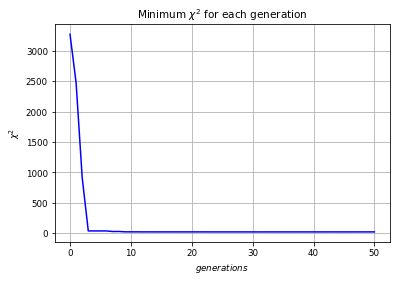

In [98]:
# 'funciones_finales' is a list with all the functions that best fit the data as a strings.
funciones_finales = recu[0]
# 'chis_finales' is a list with the minimum values of $\chi^2$.
chis_finales = recu[1]
print(funciones_finales)
print(f"Menor chi^2: {recu[1][-1]}")

z_chis= np.linspace(0, generaciones_evaluar, generaciones_evaluar + 1)
plt.xlabel('$ generations $')
plt.ylabel('$ \chi^2 $')
plt.title('Minimum $\chi^2$ for each generation')
plt.plot(z_chis,chis_finales, color = 'blue')
plt.grid(True)
plt.show()

In [99]:
'''
In order to graph the theoretical function, H(z) is defined.
'''
#Parameters
omega_r = 8.4e-5
omega_l = 0.7 - omega_r
omega_0 = 1
omega_m = 0.3
omega_k = 1 - omega_m - omega_r - omega_l

H_0= 70


#Creating the theoretical function
array_z = np.array(z)

def H_t(z):
    return H_0* ((omega_r * (1+z)**4) + omega_m * (1+z)**3 + omega_l + omega_k* (1+z)**2)**(1/2)

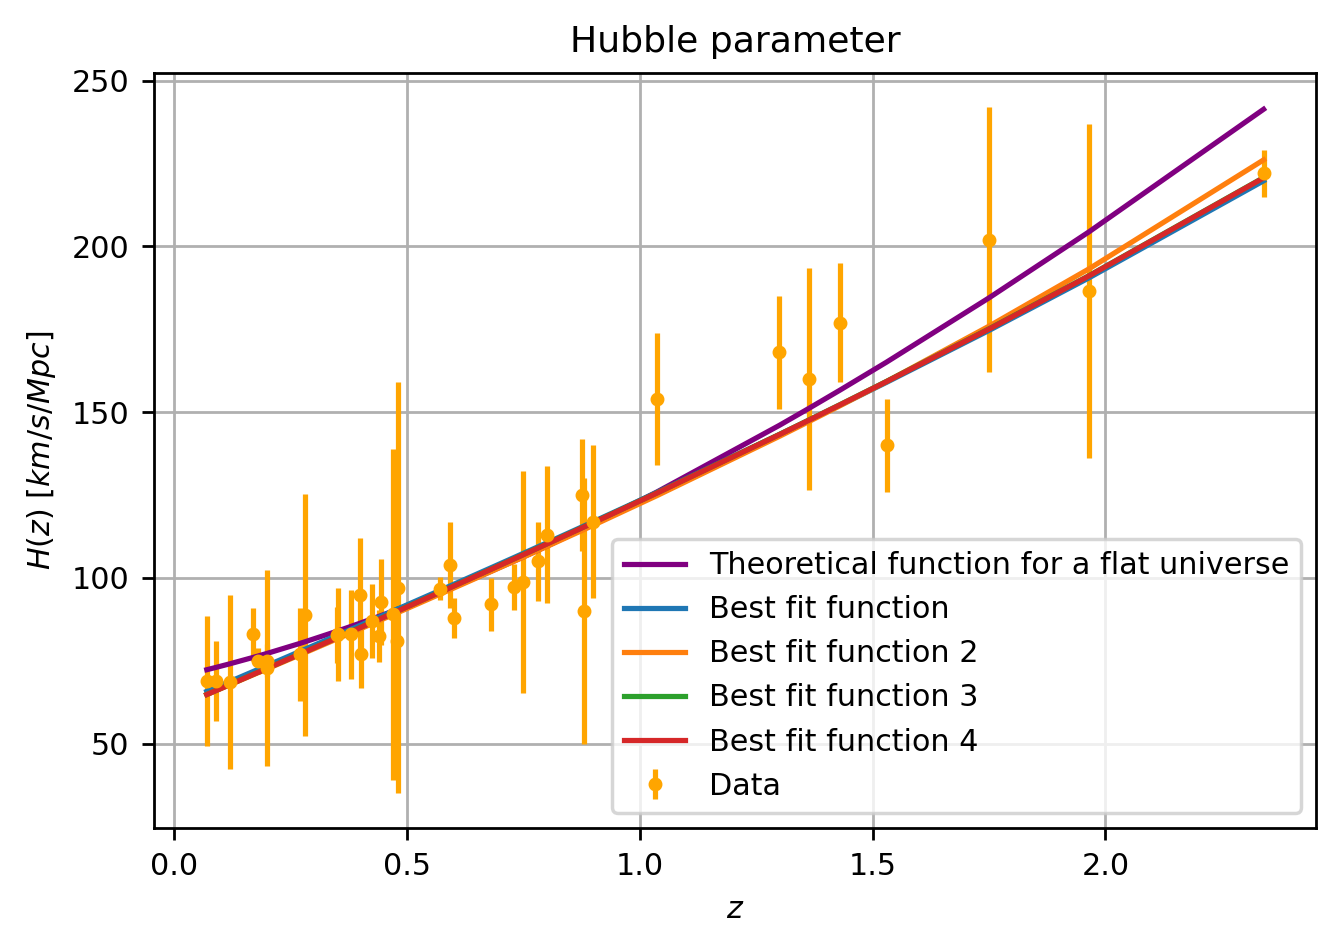

In [100]:
# Obtaining the best fit functions.
best_fit = []
for string in funciones_finales:
    a= pasar_a_funcion(string)
    best_fit.append(a)

yerr = desv
plt.rcParams.update({'font.size': 8.7})
plt.figure(dpi=250)
plt.xlabel('$ z $')
plt.ylabel('$ H(z)$ $[km/s/Mpc] $')
plt.title('Hubble parameter')

omega_0 = 1
omega_k = 1 - omega_0
plt.plot(array_z, H_t(array_z), color = 'purple', label='Theoretical function for a flat universe')
plt.plot(z, best_fit[0](z), label= 'Best fit function')
plt.plot(z, best_fit[1](z), label= 'Best fit function 2')
plt.plot(z, best_fit[2](z), label= 'Best fit function 3')
plt.plot(z, best_fit[3](z), label= 'Best fit function 4')

plt.errorbar(z, H, yerr=yerr, fmt='.', color = 'orange', label = 'Data')
plt.legend()
plt.grid(True)

plt.show()


In [101]:
# Deriving the best-fit function as a string.
ec_final = funciones_finales[0]
x = symbols('x')
a_sympy = sympify(ec_final)
# Simplifying the ecuation
a_simpli = simplify(a_sympy)
a_python = lambdify(x, a_simpli, 'numpy')

print("Ecuación final obtenida:", ec_final)
print("Ecuación final simplificada:", a_simpli)

Ecuación final obtenida: (x)**3+(x)**2+(((((((((0.4491022409860974)+1))+1))+1))+1))**3*((x)+1)/((0.4491022409860974)+1)+((0.8397075925825115)+1)-((x)+1)
Ecuación final simplificada: x**3 + x**2 + 59.77404316236861*x + 61.61375075495112


### Error analysis
1 $\sigma$ error $\delta f_i$ arround the best-fit $f_{bf}(x)$:
$$CI(x_i, \delta f_i) = 1/2  \left( \text{erf} (\dfrac{\delta f_i + f_{bf} - y_i}{\sqrt{2} \sigma_i}) + \text{erf} (\dfrac{\delta f_i - f_{bf} + y_i}{\sqrt{2} \sigma_i})\right)$$

Create a new chi-square defined as:
$$\chi_{CI}^2(\delta f_i) = \sum_{i=1}^N \left( CI(x_i, \delta f_i) - \text{erf}(1/\sqrt{2}) \right)^2$$

Parameterize with a second order polynomial $\delta f(x) = a + bx + cx^2$.

Minimize the combined chi-squared $\chi^2(f_{bf} + \delta f) + \chi_{CI}^2(\delta f)$ for the parameters (a, b, c).

The 1 $\sigma$ region for the best-fit function $f_{bf}(x)$ will be contained within the region $[f_{bf}(x)-\delta f(x), f_{bf}(x)+\delta f(x)]$.


Problems:
- It doesn't return the real parameters for the final plot with errors.

In [127]:
from scipy.special import erf
from scipy.optimize import minimize


def df(z, a, b, c):
    return a + b*z + c*z**2

def CI(z, a, b, c):
    CI = []
    for i in range(1, len(H)):
        term1 = 0.5 * (erf((1 / (np.sqrt(2)*desv[i])) * (df(z[i], a, b, c) + best_fit[0](z[i]) - H[i])))
        term2 = 0.5 * (erf((1 / (np.sqrt(2)*desv[i])) * (df(z[i], a, b, c) - best_fit[0](z[i]) + H[i])))
        CI.append(term1 + term2)
    return CI

#New chi2
def chi2CI(z, a, b, c):
    return np.sum((CI(z, a, b, c)-erf(1/np.sqrt(2)))**2)

def chi_2_f(f):
    diff = (H - f) / desv
    squared_diff = np.square(diff)
    chi_2 = np.sum(squared_diff)
    return chi_2

#Minimize the combined chi-squared
def combined_chi2(params):
    a, b, c = params
    return chi_2_f(best_fit[0](z) + df(z, a, b, c)) + chi2CI(z, a, b, c)


# Especificar las condiciones iniciales y rangos para los parámetros
initial_guess_err2 = [0.11, 0.111, 0]  # para combined_chi2[a1, a2, 0]
initial_guess_err3 = [0.11, 0.111, 0.111]  # para combined_chi2[a1, a2, a3]

# Definir los límites para los parámetros
bounds_err2 = [(0.11, 0.111), (0.11, 0.111), (0, 0)]  # límites para combined_chi2[a1, a2, 0]
bounds_err3 = [(0.11, 0.111), (0.11, 0.111), (0.11, 0.111)]  # límites para combined_chi2[a1, a2, a3]

# Encontrar el mínimo para chi2tot[a1, a2, 0]
result_err2 = minimize(combined_chi2, initial_guess_err2, bounds=bounds_err2, method='L-BFGS-B', options={'maxiter': 500})

# Encontrar el mínimo para chi2tot[a1, a2, a3]
result_err3 = minimize(combined_chi2, initial_guess_err3, bounds=bounds_err3, method='L-BFGS-B', options={'maxiter': 500})

# Imprimir los resultados
print("Mínimo para combined_chi2[a1, a2, 0]:", result_err2.fun)
print("Parámetros correspondientes:", result_err2.x)
print("\nMínimo para combined_chi2[a1, a2, a3]:", result_err3.fun)
print("Parámetros correspondientes:", result_err3.x)


Mínimo para combined_chi2[a1, a2, 0]: 38.84820425977867
Parámetros correspondientes: [0.11  0.111 0.   ]

Mínimo para combined_chi2[a1, a2, a3]: 38.64750169370264
Parámetros correspondientes: [0.111 0.111 0.111]


c:\Users\antoc\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx


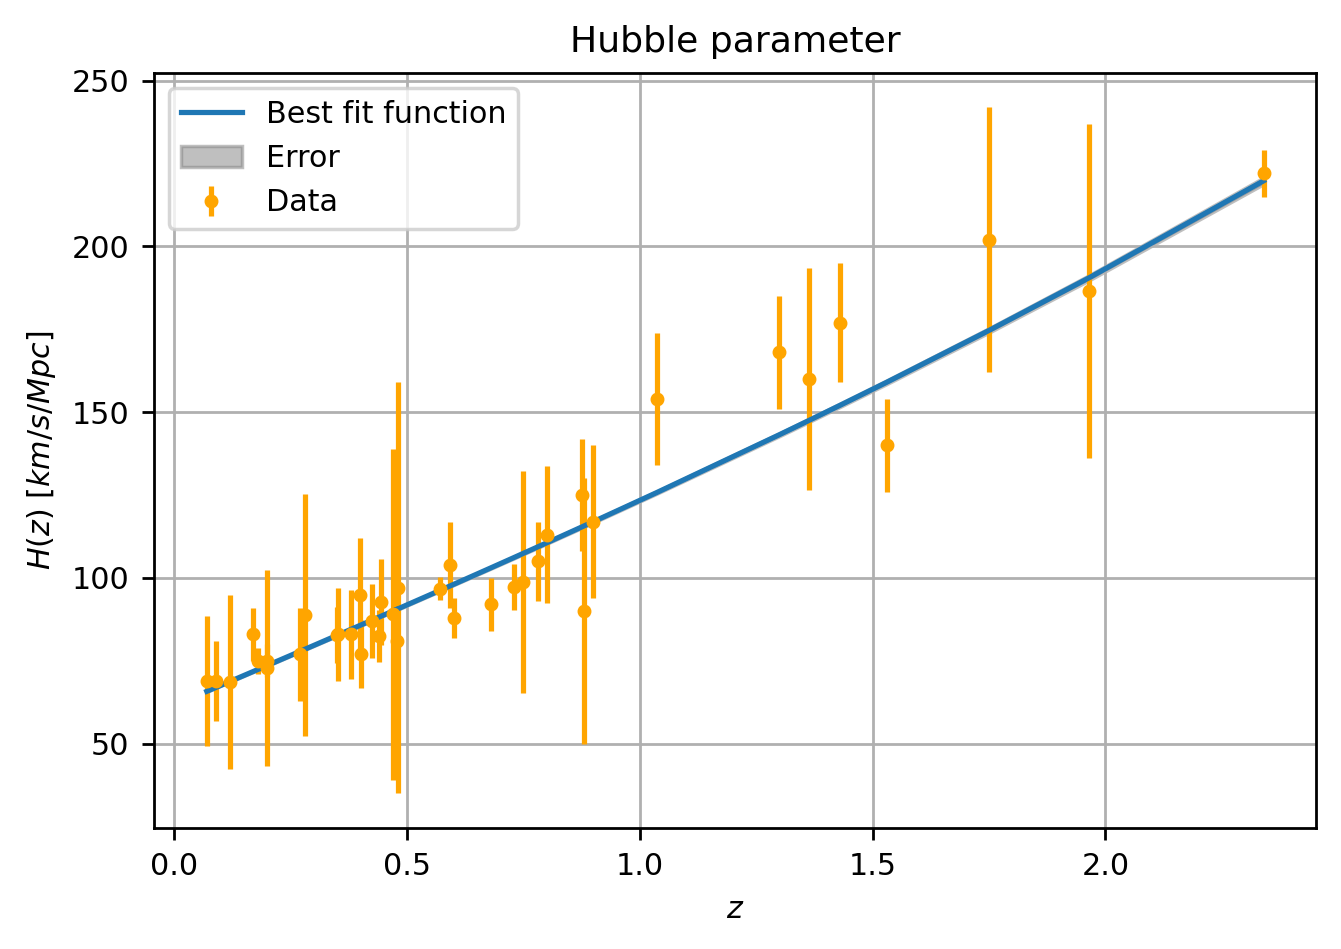

In [129]:
def error_final_posi(z):
    return a_python(z) + df(z, 0.111, 0.111, 0.111)

def error_final_neg(z):
    return a_python(z) - df(z, 0.111, 0.111, 0.111)


plt.rcParams.update({'font.size': 8.7})
plt.figure(dpi=250)

plt.xlabel('$ z $')
plt.ylabel('$ H(z)$ $[km/s/Mpc] $')
plt.title('Hubble parameter')
plt.plot(z, best_fit[0](z), label= 'Best fit function')
plt.fill_between(z, error_final_posi(z), error_final_neg(z), color='gray', alpha=0.5, label='Error')
plt.errorbar(z, H, yerr=yerr, fmt='.', color = 'orange', label = 'Data')
plt.legend()
plt.grid(True)

plt.show()